## DEMO - Training eines CNN

Verwendung in der Projektphase 2

Das Notebook zeigt beispielhaft die Durchführung folgender Schritte mit Keras:
- Vorverarbeitungsschritte der Bilder
- Trainieren eines CNNs
- Speichern und Laden
- Anwendung
- Transformation in ein TF-lite-Modell

Die verwendeten Bilder befinden sich in `/gitignore/data/images`.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from os import listdir,path
import cv2

In [4]:
# Lesen der Filenamen der Bilder in einem Ordner    
img_path = './bilder_nn/'
img_files = listdir(img_path)
# Testweises Einlesen aller Bilder -> Kontrolle der Anzahl
imgs_test = np.array([cv2.imread(img_path+i) for i in img_files])
imgs_test.shape

(531, 480, 640, 3)

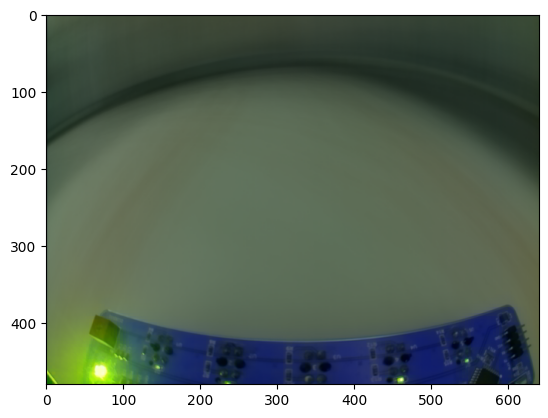

In [5]:
# Mittleres Bilder der Trainingsbilder
img_mean = imgs_test.mean(axis=0).astype('int')
plt.imshow(img_mean)

In [6]:
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image(img):
    dim = (320,150)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV) # Verwendung von Graustufenbildern
    img = img[80:380,0:640] # Ausschneiden eines Teilbildes
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    
    return img

# Laden und Vorverarbeiten aller Trainingsbilder
imgs = np.array([transform_image(cv2.imread(img_path+i)) for i in img_files])
imgs.shape

(531, 150, 320, 3)

80.33989048441096
255
0


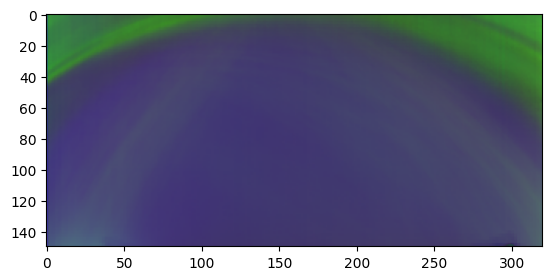

In [7]:
# Mittleres vorverarbeitetes Trainingsbild
plt.imshow(imgs.mean(axis=0).astype('int'),cmap='gray')
print(imgs.mean())
print(imgs.max())
print(imgs.min())

### Spiegeln der Bilder (Augmentation)

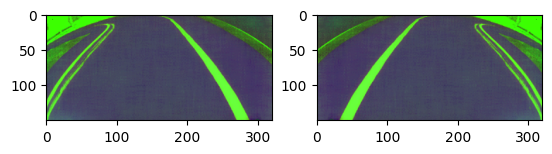

In [8]:
# Test Spiegeln eines vorverarbeiteten Bildes
imgs_mirrored = imgs[:,:,::-1]
plt.figure()
plt.subplot(121)
plt.imshow(imgs[10],cmap='gray')
plt.subplot(122)
plt.imshow(imgs_mirrored[10],cmap='gray')

In [9]:
# Zusammenfügen der ungespiegelten und der gespiegelten Trainingsdaten
print(imgs.shape)
print(imgs_mirrored.shape)
imgs_all = np.concatenate((imgs,imgs_mirrored))   #hier werden die gespiegelten Bilder zusammengefügt
print(imgs_all.shape)

(531, 150, 320, 3)
(531, 150, 320, 3)
(1062, 150, 320, 3)


### "Spiegeln" der Lenkwinkel (Agumentation)
- inklusive des Ladens/Extrahierens der Lenkwinkel aus den Dateinamen

In [10]:
# Position des Lenkwinkels im Filenamen (abhängig vom OS!)
print(img_files[0])
print(img_files[0][31:-4]) # Raspberry/Linux
##print('-',i[50:-4],'-') # Windows


Bild 2023-09-27 21:22:21_Angle_90.png
90


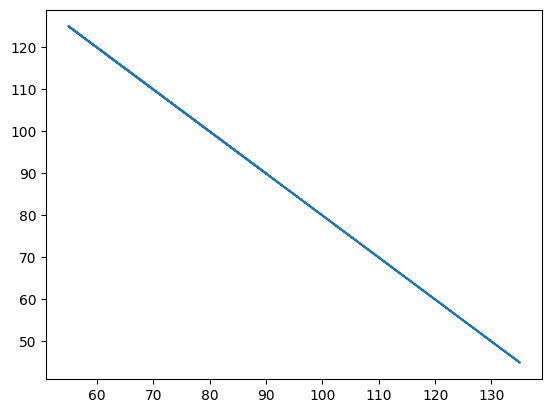

In [11]:
angles = np.array([int(i[31:-4]) for i in img_files]) # Extrahieren der Lenkwinkel aus dem Dateinamen
angles_mirrored = [-(a-90)+90 for a in angles] # Spiegeln der Winkel

# Kontrolle
plt.plot(angles,angles_mirrored)
angles_all = np.hstack((angles,angles_mirrored)) # Zusammenführen der ungespiegelten und gespiegelten Winkel

### Verteilung der Lenkwinkel

<AxesSubplot:>

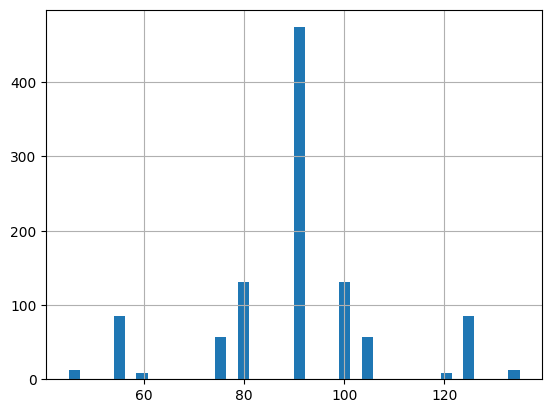

In [13]:
pd.Series(angles_all, name ='angles').hist(bins = 40)

### Einteilen der Trainingsdaten

In [15]:
# Split Trainings- und Testdaten
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(imgs_all, angles_all, test_size = 0.2, random_state = 1)

### Erstellen des NN  mit Tensorflow

In [16]:
# Korntrolle
print(X_train.dtype)
print(X_train.shape)
print(y_train.shape)
print(X_validate.dtype)
print(X_validate.shape)
print(X_validate.shape)

uint8
(849, 150, 320, 3)
(849,)
uint8
(213, 150, 320, 3)
(213, 150, 320, 3)


In [17]:
# Import notwendiger Klassen und Funktionen
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam

In [18]:
# Kontrolle bzw. Ermitteln des Shape der Eingabedaten/Inputshape
n,h,w,f=imgs_all.shape
input_shape = (h,w,f)
print(input_shape)

(150, 320, 3)


In [19]:
# Erstellen des Netzes
# Keras Sequntial API
model = tf.keras.Sequential(name='dnn') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # more robustness 
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers 
model.add(Flatten()) 
model.add(Dropout(0.2)) # more robustness 
##model.add(Dense(100, activation='elu')) 
model.add(Dense(50, activation='elu')) 
model.add(Dense(10, activation='elu'))

# Output Layer: turning angle
model.add(Dense(1)) 


In [20]:
# Kontrolle der Architektur
model.summary()

Model: "dnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 158, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 77, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 37, 48)        43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 35, 64)        27712     
_________________________________________________________________
dropout (Dropout)            (None, 14, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 33, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 25344)             0       

### Trainieren des NN

In [21]:
# Kompiliern des Modells und Wahl von Fehlerfunktion und Optimizer
model.compile(loss ='mse', optimizer=Adam(lr=0.001))

In [27]:
# Training
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs= 40,
    verbose=1,
    validation_data=(X_validate,y_validate)
)

2023-09-27 21:35:37.117784: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122256000 exceeds 10% of free system memory.
2023-09-27 21:35:38.560909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-27 21:35:38.578299: W tensorflow/core/platform/profile_utils/cpu_utils.cc:116] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


Epoch 1/40


2023-09-27 21:35:45.275501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18432000 exceeds 10% of free system memory.
2023-09-27 21:35:45.328620: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 35432448 exceeds 10% of free system memory.
2023-09-27 21:35:47.504276: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25546752 exceeds 10% of free system memory.
2023-09-27 21:35:47.830912: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25401600 exceeds 10% of free system memory.


27/27 [==============================] - 197s 7s/step - loss: 191170.6729 - val_loss: 390.4283
Epoch 2/40
27/27 [==============================] - 190s 7s/step - loss: 371.2908 - val_loss: 267.1825
Epoch 3/40
27/27 [==============================] - 186s 7s/step - loss: 279.5903 - val_loss: 240.8818
Epoch 4/40
27/27 [==============================] - 200s 7s/step - loss: 244.4725 - val_loss: 257.5067
Epoch 5/40
27/27 [==============================] - 146s 5s/step - loss: 224.3716 - val_loss: 197.6738
Epoch 6/40
27/27 [==============================] - 142s 5s/step - loss: 182.9077 - val_loss: 166.0158
Epoch 7/40
27/27 [==============================] - 136s 5s/step - loss: 184.8380 - val_loss: 184.3572
Epoch 8/40
27/27 [==============================] - 130s 5s/step - loss: 144.8070 - val_loss: 180.2263
Epoch 9/40
27/27 [==============================] - 131s 5s/step - loss: 133.5895 - val_loss: 218.6096
Epoch 10/40
27/27 [==============================] - 131s 5s/step - loss: 141.893

In [28]:
def train_loss_acc_plot(history,skip=0):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'][skip:], label='Loss')
    plt.plot(history.history['val_loss'][skip:], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

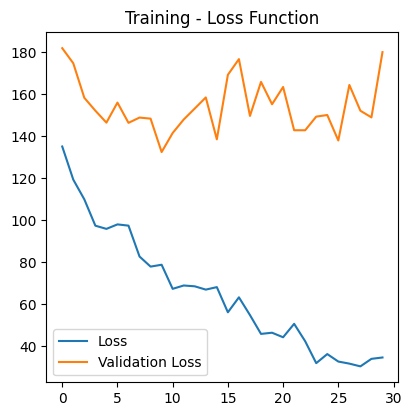

In [29]:
# Begutachtung des Trainingsverlaufs
train_loss_acc_plot(history,skip=10)

In [ ]:
# Eventuelle weiteres Training
history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs= 10,
    verbose=1,
    validation_split=.3
)

In [30]:
# Trainings- und Testfehler
mse_train = model.evaluate(X_train,y_train)
mse_validate = model.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

7/7 [==============================] - 12s 2s/step - loss: 179.9333
MSE train/val: 67.0737 / 179.9333
RMSE train/val: 8.1899 / 13.4139


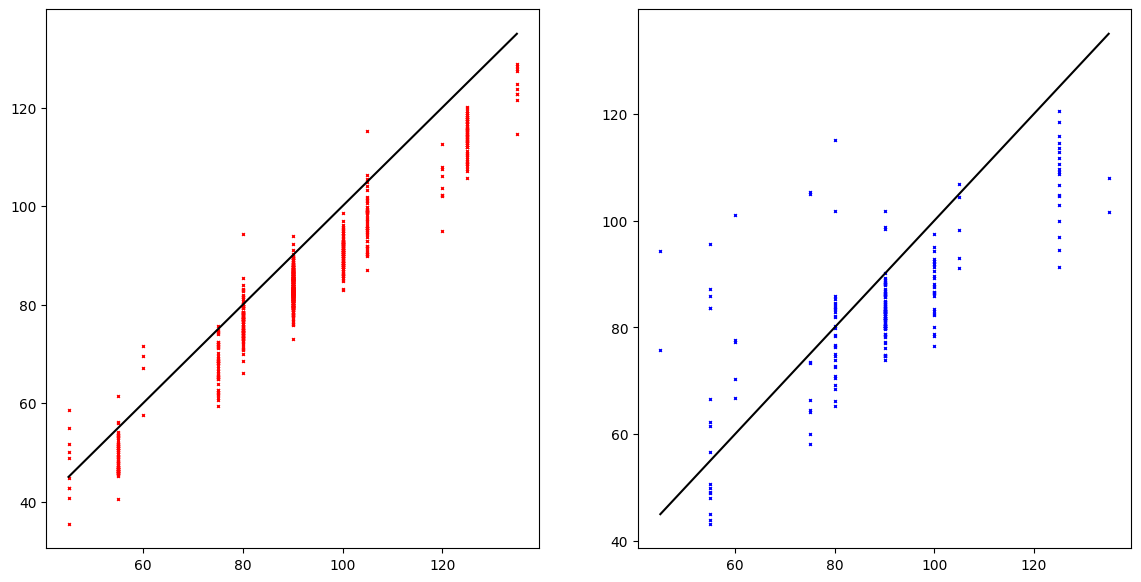

In [31]:
# Visualisierung der Fehler
y_train_p = model.predict(X_train)
y_validate_p = model.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

In [32]:
# Speichern des trainierten Modells
#path_to_model_file = './DEMO_MODEL.h5'# Speichert im H5-Format
path_to_model_file = './DEMO_MODEL' # Speichert im SavedModel-Format
model.save(path_to_model_file)

2023-09-27 23:29:19.539643: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./DEMO_MODEL/assets


## Verwendung eines trainierten Modells

In [33]:
# Laden eines Modells
path_to_model_file = './DEMO_MODEL'
model_loaded = tf.keras.models.load_model(path_to_model_file)

In [34]:
# Shape des Input-Layers
model_loaded.layers[0].input_shape

(None, 150, 320, 3)

In [35]:
mse_train = model_loaded.evaluate(X_train,y_train)
mse_validate = model_loaded.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

7/7 [==============================] - 11s 2s/step - loss: 179.9333
MSE train/val: 67.0737 / 179.9333
RMSE train/val: 8.1899 / 13.4139


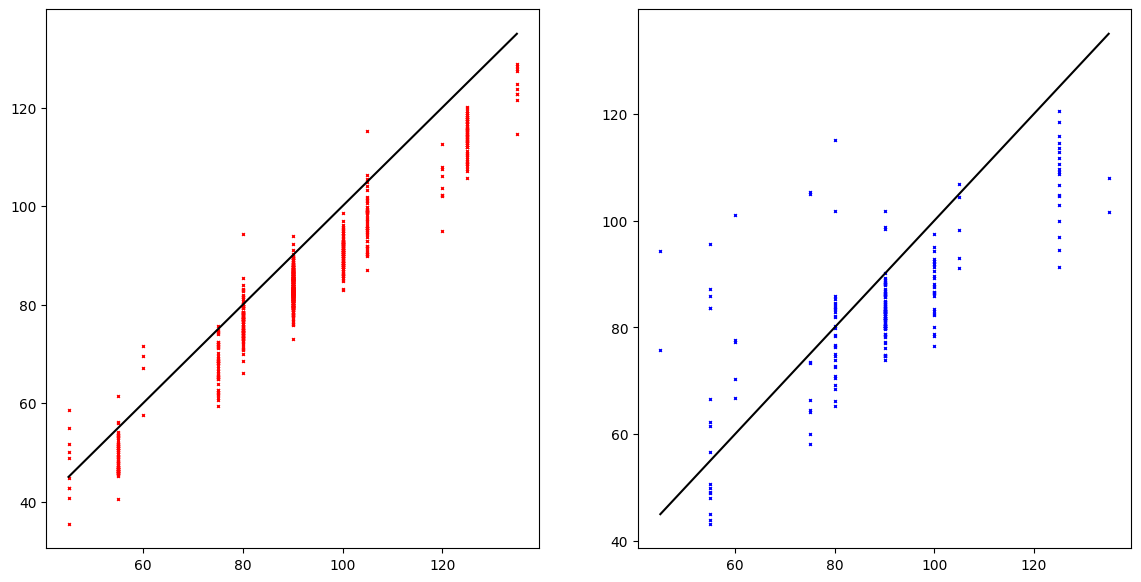

In [36]:
# Visualisierung der Fehler
y_train_p = model_loaded.predict(X_train)
y_validate_p = model_loaded.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

### Anwendung des Netzes zur Bestimmung des Lenkwinkels

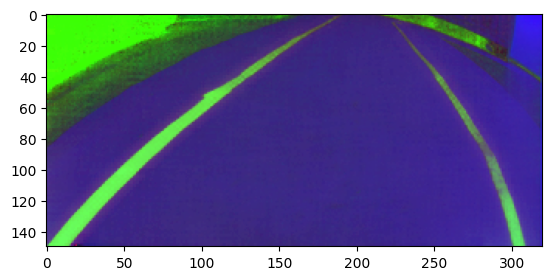

In [41]:
# Wahl eines Beispielbildes!
xe = np.array( [X_train[2]] )
xe.shape
plt.imshow(X_train[2])

In [39]:
# Mittels der Methode __call__ 
model_loaded(xe).numpy()

array([[66.51081]], dtype=float32)